In [4]:
import sys
sys.path.append("..")

from tools.display_tools import plot_current_state_of_graph
import pickle
import numpy as np
import pandas as pd


from wetterdienst.provider.dwd.observation import (
    DwdObservationDataset,
    DwdObservationRequest,
    DwdObservationResolution,
)
from datetime import datetime
from matplotlib.lines import Line2D


## Tutorial on how to use weather information from the DWD to select specific windows.

As an example, we here use this information to monthly period with as little as possible rain for the area of the flood graph

(We use this set during Experiment 2 in our paper)

In [5]:
# Load graph base and extract measurement station coordinates from the graph.
G = pickle.load(open("product/rivers_flood.p", "rb"))
bb_box = np.array(
    list(np.array([G.nodes[x]["p"] for x in G.nodes]).max(axis=0))
    + list(np.array([G.nodes[x]["p"] for x in G.nodes]).min(axis=0))
)

In [6]:
# Most stations only provide data until 2023. Select window from here.
requests = DwdObservationRequest(
    parameter=DwdObservationDataset.PRECIPITATION_MORE,
    resolution=DwdObservationResolution.DAILY,
    start_date=datetime(2019, 1, 1),
    end_date=datetime(2023, 1, 1),
)

In [7]:
# Filter my location
res = requests.filter_by_bbox(bb_box[3],bb_box[2],bb_box[1],bb_box[0]-0.2).df

# Filter by time
c1 = res["end_date"].dt.year() > 2022
c2 = res["start_date"].dt.year() < 2019

selection = []
for n in range(len(c1)):
    if c1[n] and c2[n]: 
        selection.append(n)
res = res[selection]

In [8]:
plot_res = pd.DataFrame(res)
plot_res[8] = "WS"

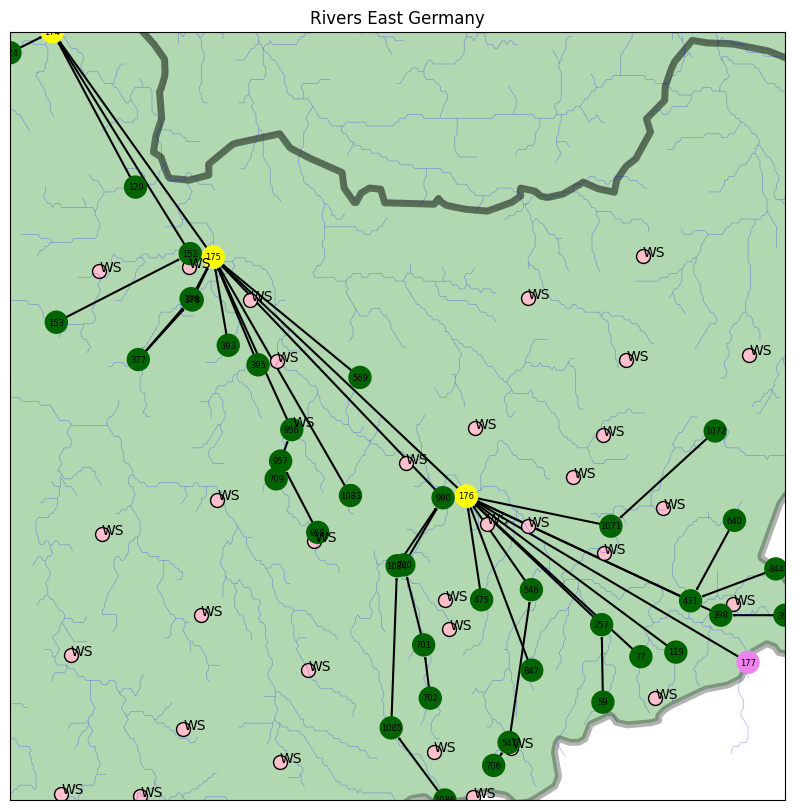

In [9]:
# Plot the flood graph and the weather stations that are close.
plot_current_state_of_graph(
    G,
    lim=(bb_box[2], bb_box[0]),
    limx=(bb_box[3], bb_box[1]),
    node_size=250,
    save=0,
    river_map=True,
    ger_map=True,
    width=1.5,
    arrowsize=1,
    fs=(10, 10),
    font_size=6,
    extra_points=plot_res[[4,3,8]].to_numpy()
)

In [10]:
# We now remove stations that are too far away from the actual stations. As these are few, we do it by hand.
remove =["02887","04023", "03094", "00822", "03683", "01022", "01252", "01441", "00579", "07327", "05436", "05700", "01022", "06314"]
selection = []
for n,x in enumerate((res["station_id"])):
    if x not in remove:
        selection.append(n)
res = res[selection]

In [11]:
plot_res = pd.DataFrame(res)
plot_res[8] = ""

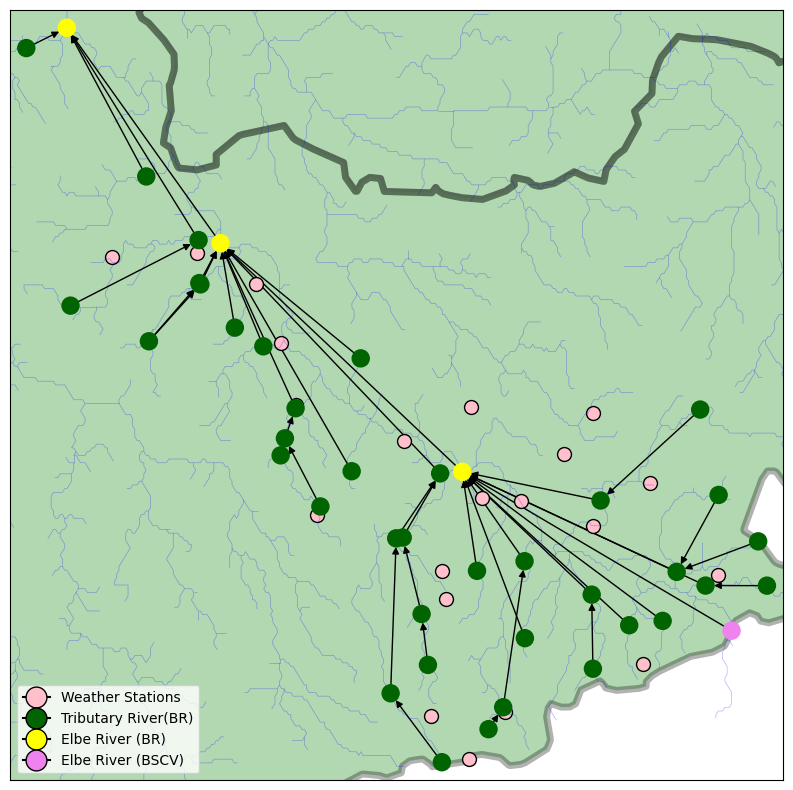

In [12]:
# Full Graph

legend_elements = [Line2D([0], [0], marker='o', color='black', label='Weather Stations',
                        markerfacecolor='pink', markersize=15),
                Line2D([0], [0], marker='o', color='black', label='Tributary River(BR)',
                        markerfacecolor='darkgreen', markersize=15),
                Line2D([0], [0], marker='o', color='black', label='Elbe River (BR)',
                        markerfacecolor='yellow', markersize=15),
                    Line2D([0], [0], marker='o', color='black', label='Elbe River (BSCV)',
                        markerfacecolor='violet', markersize=15)]



plot_current_state_of_graph(
    G,
    lim=(bb_box[2]-0.02, bb_box[0]+0.02),
    limx=(bb_box[3]-0.03, bb_box[1]+0.03),
    node_size=150,
    river_map=True,
    ger_map=True,
    width=1,
    arrowsize=10,
    fs=(10, 10),
    label=False,
    extra_points=plot_res[[4,3,8]].to_numpy(),
    title="",
    custom_legend= (legend_elements, "lower left"),
    log_scale = False
)

In [13]:
# Get the data from the selected stations.
stations = requests.filter_by_station_id(station_id=res["station_id"])

In [14]:
#query the data and concat everything into a table
data = []
for result in stations.values.query():
    data.append(result.df[list(np.where(result.df["parameter"] == "precipitation_height")[0])])

stack = []
for x in data:
    name = x["station_id"][0]
    df = x["date", "value"].to_pandas()
    df.index = df.date.values
    df.drop(columns="date", inplace=True)
    df.columns = [name]
    stack.append(df)
prec = pd.concat(stack,axis=1)

/home/stein/anaconda3/envs/causal_rivers_core/lib/python3.13/site-packages/wetterdienst/provider/dwd/observation/parser.py:151: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  df = df.drop(col for col in DROPPABLE_PARAMETERS if col in df.columns)
/home/stein/anaconda3/envs/causal_rivers_core/lib/python3.13/site-packages/wetterdienst/core/timeseries/values.py:245: MapWithoutReturnDtypeWarning: 'return_dtype' of function python_udf must be set

A later expression might fail because the output type is not known. Set return_dtype=pl.self_dtype() if the type is unchanged, or set the proper output data type.
  group = group.with_columns(pl.col(Columns.VALUE.value).map_batches(lambda s, o=op, f=factor: o(s, f)))


In [15]:
prec.isnull().sum()

00991       0
01048       0
01050       0
01051      24
01693       0
01854    1462
02530       0
02882       0
02985       0
03234       0
03740       0
03811       0
04047       0
04197       0
04432       0
04895       0
05746       0
05779      15
05943       1
07334       0
13654       0
dtype: int64

In [16]:
# Calculate the sum of all stations and over a rolling window to find intervals with, in this case, low precipitation.
prec_sum = prec.sum(axis=1,skipna=True)
result = prec_sum.rolling(30,min_periods=30).mean()
mini = result.nsmallest(200)

In [17]:
# Check the ones that represents full months.
mini[mini.index.day == 30]

2020-04-30     3.433333
2020-11-30     5.913333
2021-10-30     9.826667
2022-03-30    10.390000
2020-12-30    14.340000
2022-07-30    14.510000
2020-01-30    14.713333
2022-10-30    16.073333
dtype: float64

In [18]:
# We have to prevent selecting an interval with many missing values.
data = pd.read_csv("product/rivers_ts_east_germany.csv", index_col=0)
data = data[[str(x) for x in list(G.nodes)]]

In [19]:
# First period has a completely missing ts for this time...
c1 = pd.to_datetime(data.index).year == 2020
c2 = pd.to_datetime(data.index).month == 4
data[c1 & c2].isnull().sum().max() / len(data[c1 & c2])

np.float64(1.0)

In [20]:
# First period has a completely missing ts for this time...
c1 = pd.to_datetime(data.index).year == 2020
c2 = pd.to_datetime(data.index).month == 11
data[c1 & c2].isnull().sum().max() / len(data[c1 & c2])

np.float64(1.0)

In [21]:
# Third option seems to be nice.
c1 = pd.to_datetime(data.index).year == 2021
c2 = pd.to_datetime(data.index).month == 10
data[c1 & c2].isnull().sum().max() / len(data[c1 & c2])

np.float64(0.17036290322580644)

In [22]:
# Candidate set: Oktober 2021, as periods with lower precipitation have too much missing data.
index = np.where(result.index == "2021-10-31")[0][0]
prec.iloc[index-31: index].sum(axis=1).mean()

np.float64(9.50967741935484)

This is the subselection we take during experiment 2: ***10, 2021***. 
 
 One month of data with basically no rain (We evaluate this subsection in experiment set 2)